In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
import numpy as np
import os
import matplotlib.pyplot as plt
import random
from tqdm import tqdm, trange

In [34]:
!curl -O https://noname-1256719566.cos.ap-nanjing.myqcloud.com/project.zip
!unzip project.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 89.0M  100 89.0M    0     0  4340k      0  0:00:21  0:00:21 --:--:-- 12.4M
Archive:  project.zip
replace project/training_data/2972_lig_cg.pdb? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [35]:
def read_pdb(filename):
    with open(filename, 'r') as file:
        strline_L = file.readlines()

    X_list = list()
    Y_list = list()
    Z_list = list()
    atomtype_list = list()
    for strline in strline_L:
        # removes all whitespace at the start and end, including spaces, tabs, newlines and carriage returns
        stripped_line = strline.strip()

        line_length = len(stripped_line)
        # print("Line length:{}".format(line_length))
        if line_length < 78:
            print("ERROR: line length is different. Expected>=78, current={}".format(line_length))
            
        X_list.append(float(stripped_line[30:38].strip()))
        Y_list.append(float(stripped_line[38:46].strip()))
        Z_list.append(float(stripped_line[46:54].strip()))

        atomtype = stripped_line[76:78].strip()
        if atomtype == 'C':
            atomtype_list.append(0) # 'h' means hydrophobic
        else:
            atomtype_list.append(1) # 'p' means polar
    X_list = np.array(X_list)[:,np.newaxis]
    Y_list = np.array(Y_list)[:,np.newaxis]
    Z_list = np.array(Z_list)[:,np.newaxis]
    atomtype_list = np.array(atomtype_list)
    pos = np.concatenate([X_list, Y_list,Z_list],axis=1)
    return pos, atomtype_list

In [36]:
OFFSET = np.array([100,100,100])
CUBE_CENTER = 128
CUBE_SIZE = 256
RESCALE_CUBE_SIZE = 32
RESCALE = 8
NEG_SAMPLE_RATIO = 2

In [37]:
def trim_rescale_pos(pos):
    rescaled_pos = []
    for i in range(3):
        pos_rescale = int(pos[i] / RESCALE)
        pos_rescale = 0 if pos_rescale <0 else pos_rescale
        pos_rescale = RESCALE_CUBE_SIZE - 1 if pos_rescale >=RESCALE_CUBE_SIZE else pos_rescale
        rescaled_pos.append(pos_rescale)
    return rescaled_pos

def normalize(pro_pos, pro_atom, lig_pos, lig_atom):
    cube_center = np.array([CUBE_CENTER,CUBE_CENTER,CUBE_CENTER])
    lig_pos_mean = np.mean(lig_pos, axis=0)
    lig_pos = cube_center + lig_pos - lig_pos_mean
    pro_pos = cube_center + pro_pos - lig_pos_mean

    lig_pos_cube = np.zeros([RESCALE_CUBE_SIZE,RESCALE_CUBE_SIZE,RESCALE_CUBE_SIZE])
    pro_pos_cube = np.zeros([RESCALE_CUBE_SIZE,RESCALE_CUBE_SIZE,RESCALE_CUBE_SIZE])
    
    for pos_iter, atom_iter in zip(pro_pos, pro_atom):
        x,y,z = trim_rescale_pos(pos_iter)
        if atom_iter == 1:
            pro_pos_cube[x,y,z] = 1.0
        else:
            pro_pos_cube[x,y,z] = -1.0
    for pos_iter, atom_iter in zip(lig_pos, lig_atom):  
        x,y,z = trim_rescale_pos(pos_iter)
        if atom_iter == 1:
            lig_pos_cube[x,y,z] = 1.0
        else:
            lig_pos_cube[x,y,z] = -1.0    
    
    return pro_pos_cube, lig_pos_cube

def generate_pair_sample(pro_file, lig_file):
    pro_pos, pro_atom = read_pdb(pro_file)
    lig_pos, lig_atom = read_pdb(lig_file)
    pro_pos_cube, lig_pos_cube =  normalize(pro_pos, pro_atom, lig_pos, lig_atom)
    return np.stack([pro_pos_cube, lig_pos_cube],axis=3 )

def construct_samples(data_dir):
    pos_samples = []
    neg_samples = []
    pro_file_names = []
    lig_file_names = []
    for file in os.listdir(data_dir):
        file_name = os.path.join(data_dir, file)
        if "lig" in file_name:
            lig_file_names.append(file_name)
        else:
            pro_file_names.append(file_name)
    
    lig_file_names.sort()
    pro_file_names.sort()
    
    assert len(pro_file_names) == len(lig_file_names)
    file_size = len(pro_file_names)
    for i in trange(file_size):
        pro_file = pro_file_names[i]
        pos_lig_file = lig_file_names[i]
        
        #create positive pair
        pos_sample = generate_pair_sample(pro_file, pos_lig_file)
        pos_samples.append(pos_sample)
        
        #create negative pair
        randomlist = random.sample(range(0, file_size), NEG_SAMPLE_RATIO)
        for neg_idx in randomlist:
            if neg_idx == i:
                continue
            neg_lig_file = lig_file_names[neg_idx]
            neg_samples.append(generate_pair_sample(pro_file, neg_lig_file))
    return pos_samples, neg_samples

In [ ]:
pos_samples, neg_samples = construct_samples("project/training_data")

(None, 30, 30, 30, 32)
(None, 15, 15, 15, 32)
(None, 13, 13, 13, 16)
(None, 6, 6, 6, 16)
(None, 4, 4, 4, 16)
(None, 2, 2, 2, 16)
(None, 128)
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 32, 2)]   0         
                                                                 
 conv3d_24 (Conv3D)          (None, 30, 30, 30, 32)    1760      
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 15, 15, 15, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 13, 13, 13, 16)    13840     
                                                                 
 max_pooling3d_25 (MaxPoolin  (None, 6, 6, 6, 16)      0         
 g3D)                                             

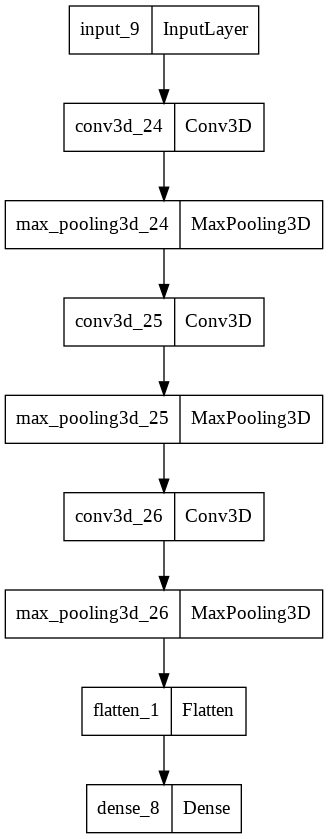

In [47]:
from keras.layers import Conv3D,Input, MaxPooling3D, Flatten, Dense
from keras.models import Model
from tensorflow.keras.utils import plot_model

img = Input(shape=[RESCALE_CUBE_SIZE, RESCALE_CUBE_SIZE, RESCALE_CUBE_SIZE, 2])

x = Conv3D(filters=32, kernel_size=(3,3,3))(img)
print(x.shape)
x = MaxPooling3D()(x)
print(x.shape)
x = Conv3D(filters=16, kernel_size=(3,3,3))(x)
print(x.shape)
x = MaxPooling3D()(x)
print(x.shape)
x = Conv3D(filters=16, kernel_size=(3,3,3))(x)
print(x.shape)
x = MaxPooling3D()(x)
print(x.shape)
x = Flatten()(x)
print(x.shape)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=img, outputs=output)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
plot_model(model)

In [40]:
X = pos_samples + neg_samples
Y = [1 for _ in range(len(pos_samples))] + [0 for _ in range(len(neg_samples))]
X = np.array(X)
Y = np.array(Y)

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [45]:
from keras.callbacks import ModelCheckpoint
model_checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/BS6207/project_backup/best_model.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=[X_test, y_test], callbacks=[model_checkpoint_callback])

In [ ]:
import time 
while True: time.sleep(10000)

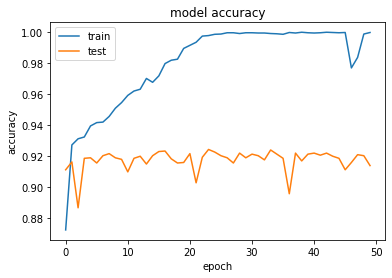

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

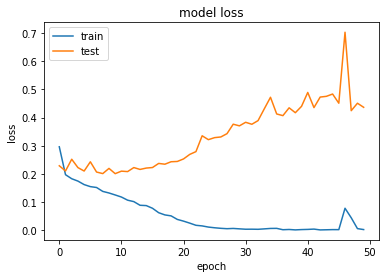

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [74]:
#inference
lig_file_names = []
pro_file_names = []
test_dir = "testing_data_release/testing_data"
for file in os.listdir(test_dir):
    file_name = os.path.join(test_dir, file)
    if "lig" in file_name:
        lig_file_names.append(file_name)
    else:
        pro_file_names.append(file_name)
    
lig_file_names.sort()
pro_file_names.sort()

pro_pos_list = []
pro_atom_list = []
lig_pos_list = []
lig_atom_list = []
for file in pro_file_names:
    pro_pos, pro_atom = read_pdb_for_test(file)
    pro_pos_list.append(pro_pos)
    pro_atom_list.append(pro_atom)

for file in lig_file_names:
    lig_pos, lig_atom = read_pdb_for_test(file)
    lig_pos_list.append(lig_pos)
    lig_atom_list.append(lig_atom)

def construct_inference_data(pro_pos, pro_atom, lig_pos_list, lig_atom_list):
    batch_data = []
    for lig_pos,lig_atom in zip(lig_pos_list, lig_atom_list):
        batch_data.append(generate_pair_sample_for_test(pro_pos,pro_atom,lig_pos,lig_atom))
    return batch_data

def read_pdb_for_test(filename):
    with open(filename, 'r') as file:
        strline_L = file.readlines()

    X_list = list()
    Y_list = list()
    Z_list = list()
    atomtype_list = list()
    for strline in strline_L:
        # removes all whitespace at the start and end, including spaces, tabs, newlines and carriage returns
        stripped_line = strline.strip()
        parts = stripped_line.split("\t")
        
        X_list.append(float(parts[0]))
        Y_list.append(float(parts[1]))
        Z_list.append(float(parts[2]))

        atomtype = parts[3].strip()
        if atomtype == 'h':
            atomtype_list.append(0) # 'h' means hydrophobic
        else:
            atomtype_list.append(1) # 'p' means polar
    X_list = np.array(X_list)[:,np.newaxis]
    Y_list = np.array(Y_list)[:,np.newaxis]
    Z_list = np.array(Z_list)[:,np.newaxis]
    atomtype_list = np.array(atomtype_list)
    pos = np.concatenate([X_list, Y_list,Z_list],axis=1)
    return pos, atomtype_list
    

def generate_pair_sample_for_test(pro_pos,pro_atom,lig_pos,lig_atom):
    pro_pos_cube, lig_pos_cube =  normalize(pro_pos, pro_atom, lig_pos, lig_atom)
    return np.stack([pro_pos_cube, lig_pos_cube],axis=3 )


In [76]:
results = []
for idx in range(len(pro_pos_list)):
    if idx % 50 == 0:
        print("processed " , idx + 1);
    pro_pos = pro_pos_list[idx]
    pro_atom = pro_atom_list[idx]
    batch_data = construct_inference_data(pro_pos,pro_atom,lig_pos_list, lig_atom_list)
    res = model.predict(np.array(batch_data))
    results.append(np.argsort(-res.flatten())[0:10])

In [77]:
with open("prediction.txt", "w") as f:
    f.write("pro_id\t")
    lig_strs = ["lig{}_id".format(idx+1) for idx in range(10)]
    f.write("\t".join(lig_strs))
    f.write("\n")
    for idx,result in enumerate(results):
        f.write("{}\t".format(idx+1))
        result_list = result.tolist()
        result_str = [str(f+1) for f in result_list]
        result_str = "\t".join(result_str)
        f.write(result_str)
        if idx != len(results) -1 :
            f.write("\n")